In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("mobile_prices.csv")
df.head()

battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  
3        1             0     0            2  
4        1             1     0            1  

[5 rows x 21 columns]

In [2]:
df.shape

(2000, 21)

In [3]:
df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

In [4]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [5]:
df['price_range'].unique()

array([1, 2, 3, 0], dtype=int64)

In [6]:
X = df.copy()
y = X.pop("price_range")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

ram          0.848922
px_width     0.027747
sc_h         0.012139
fc           0.000867
m_dep        0.000000
pc           0.000000
talk_time    0.000000
Name: MI Scores, dtype: float64

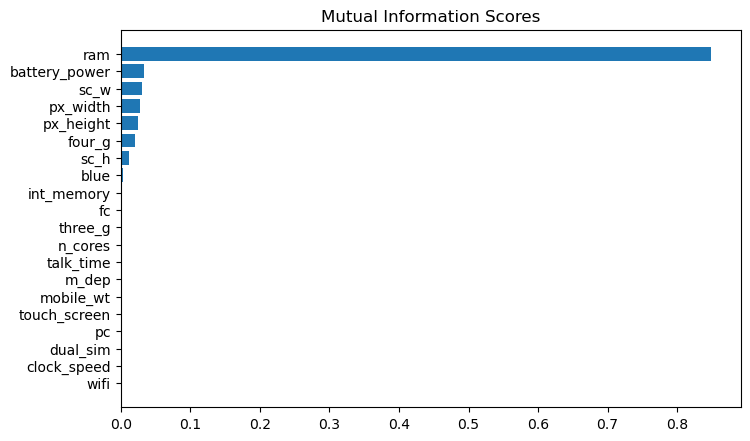

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [13]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [10]:
features = [
    "ram",
    "battery_power",
    "sc_w",
    "px_width",
    "px_height",
    "four_g",
    "sc_h"
]

In [11]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [14]:
X = df.copy()
y = X.pop("price_range")
X = X.loc[:, features]

pca, X_pca, loadings = apply_pca(X)
print(loadings)

                    PC1       PC2       PC3       PC4       PC5       PC6  \
ram            0.030633 -0.077250 -0.225662 -0.962414  0.117710  0.044328   
battery_power -0.036945  0.061297 -0.694795  0.238240  0.673836 -0.013553   
sc_w           0.503656 -0.487841  0.004932  0.041460  0.072415 -0.565471   
px_width       0.484141  0.514182 -0.019314 -0.054485 -0.057275 -0.438334   
px_height      0.502856  0.496312 -0.002251  0.004791  0.015045  0.439683   
four_g         0.043904 -0.083632 -0.681538  0.081785 -0.719783  0.036082   
sc_h           0.504820 -0.484338  0.037963  0.074839  0.072465  0.539754   

                    PC7  
ram           -0.010424  
battery_power  0.033789  
sc_w          -0.426143  
px_width       0.549968  
px_height     -0.554288  
four_g        -0.022494  
sc_h           0.454913  
